In [6]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

# Algorithm for identifying plasma boundary in a tokamak

In this notebook an algotirthm for the identification of the plasma boundary in a tokamak is built in several steps:
1. Given a fixed value of $\psi_0$, identify the magnetic surface $\psi = \psi_0$;
2. Given the position of the limiter/divertor (as a set of points), identify the plamsa boundary;
3. Given the limiter as a line, identify the plasma boundary; 
4. Generate a new mesh region based on the detected plasma boundary.

### STEP 0: Compute a solution of Grad-Shafranov

The algorithm developed here should be employed to compute the plasma boundary within the solution of the free-boundary Grad-Shafranov problem. However, this algorithm is in fact independent on the free-boundary problem itself, so to start with the development a numerical solution of a Solov'ev equilibrium in a prescribed domain context is employed.

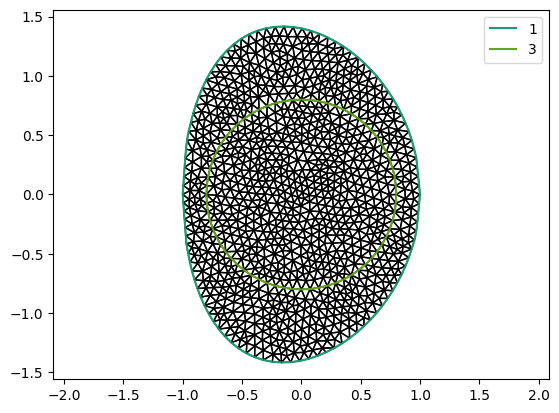

In [7]:
# Import Mesh:
#mesh = Mesh(r"../Meshes/D_mesh/D_mesh_3.msh")
mesh = Mesh(r"../Meshes/D_mesh/D_mesh_lim.msh")

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend()
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

In [8]:
def GradShafranov(G, Cartesian = False, bc = DirichletBC(V, 0.0, 'on_boundary'), initial_guess = None):

  # Define trial and test functions:
  psi = Function(V, name="Flux Function")
  phi = TestFunction(V)

  # Define the variational problem:
  if (Cartesian == False):
    L  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx - (G(x,psi) * phi) * dx # for toroidal coordinates
  else:
    L = dot(grad(psi), grad(phi))/(1 + eps*x) * dx - r0**2 / (1 + eps*x) * G(x,psi) * phi * dx # for Cartesian nondimensional coordinates

  # Customize initial guess:
  if initial_guess is not None:
    # Create the initial guess based on the provided function:
    psi.interpolate(initial_guess(x,y))

  # Solve with Newton's iterative method:
  solve(L == 0, psi, bcs=bc,
        solver_parameters={'snes_type': 'newtonls',
                          'snes_monitor': None,
                          'ksp_type': 'preonly',
                          'pc_type': 'lu'}
        )

  return psi

  0 SNES Function norm 4.162157134228e-01
  1 SNES Function norm 2.124991318101e-05
  2 SNES Function norm 1.162454293199e-09


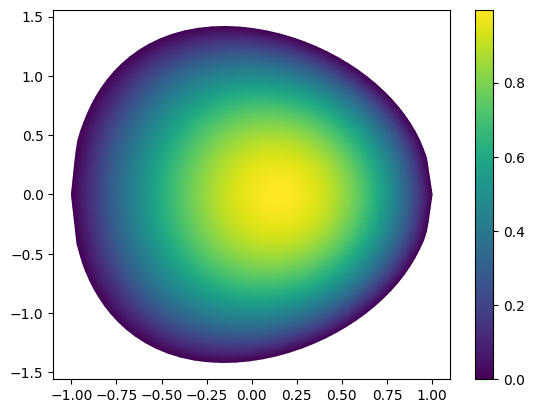

In [9]:
# Define parameters for the D-shape:
R0 = 5/3          # major radius
r0 = 1/2          # minor radius
tau = 0           # triangularity
eps = r0 / R0     # aspect ratio
b = 1 - eps       # elongation

# G1(psi) = alpha = costant, G2(psi) = beta = constant:
alpha = ( 4*(r0**2+b**2)*eps + r0**2 * (2*tau - eps**3) ) / ( 2*R0**2 * eps * r0**2 * b**2)
beta = - tau / (eps * b**2)

# Define G1 and G2 as functions of cartesian coordinates
# Solver uses toroidal coordinates, the input variables
def G(x,psi):
  return alpha * (R0 * (1+eps*x))**2 + beta

# Numerical solution:
psi = GradShafranov(G, Cartesian = True, bc = DirichletBC(V, 0.0, 'on_boundary'))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q)

### STEP 1: Identify magnetic surface "$\psi = \psi_0$" given $\psi_0$

In the solution above, $\psi \in [0,1]$. Hence I fix a $\psi_0$ within the range.

In [10]:
x_min, x_max = -1, 1
y_min, y_max = -1.5, 1.5
Nx, Ny = 500, 500

# Create the grid
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
PSI = np.zeros_like(X)

for i in range(Nx):
    for j in range(Ny):
        point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
        try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
        except:
            PSI[j, i] = np.nan         # Mark outside points as nan

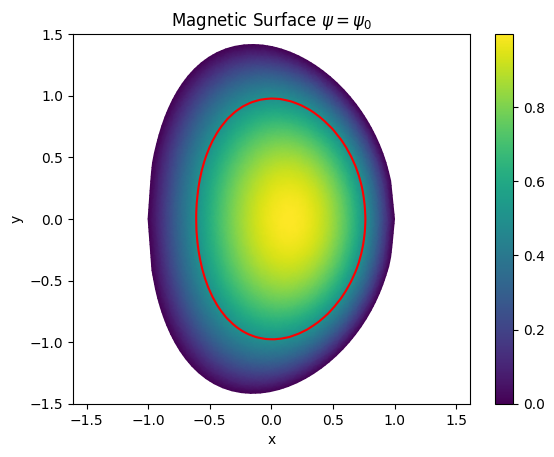

In [11]:
psi0 = 0.5  # example value, adjust to your case

fig, ax = plt.subplots()
fig.colorbar(tripcolor(psi, axes=ax))
plt.contour(X, Y, PSI, levels=[psi0], colors='red')  # extract and plot psi=psi0
plt.title(r"Magnetic Surface $\psi = \psi_0$")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

### STEP 2: LIMITER IS A SET OF POINTS

Even if there have been defined points embedded in the geometry, also as physical point, apparently FireDrake is not able to "detect" them when importing the mesh. I am forced to define "manually" such points in the mesh.

In [12]:
# Set of points for the limiter:
limiter_points = [(0.7, 0.0), (-0.2, -1.0), (0.2, -1.0)]
psi_vals = []
for (x_pt, y_pt) in limiter_points:
    try:
        psi_val = psi.at((x_pt, y_pt))
        psi_vals.append(psi_val)
    except:
        raise ValueError(f"Point {(x_pt, y_pt)} outside domain!")

psi0 = max(psi_vals)

Questo di "ridefinire" la mesh come griglia "ordinata" solo per individuare il contour mi sembra un passaggio troppo oneroso e potrebbe essere inutile dato che mia mesh è già definita (?). Tuttavia non saprei bene come fare in modo più efficiente.

In [13]:
# Evaluate the function on the grid
PSI = np.zeros_like(X)

for i in range(Nx):
    for j in range(Ny):
        point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
        try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
        except:
            PSI[j, i] = np.nan         # Mark outside points as nan

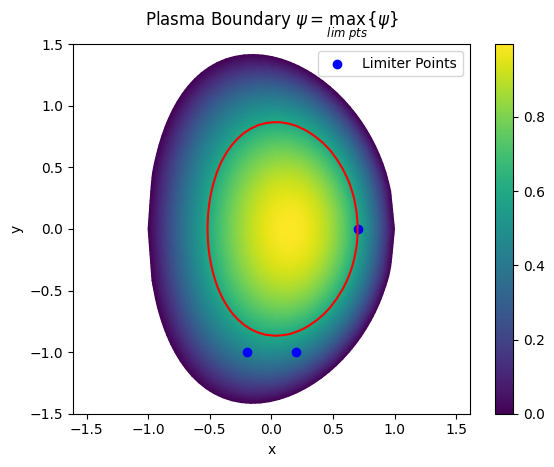

In [14]:
# Plot
fig, ax = plt.subplots()
fig.colorbar(tripcolor(psi, axes=ax))
plt.contour(X, Y, PSI, levels=[psi0], colors='red')
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
plt.title(r"Plasma Boundary $\psi = \max_{lim\ pts}\{\psi\}$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

### STEP 3: LIMITER IS AN EMBEDDED LINE IN THE MESH

In [22]:
# Compute max(psi) at the limiter points:
limiter_nodes = DirichletBC(V, 0.0, 3).nodes # Use BCs as a tool to extract the limiter nodes
psi0 = max(psi.dat.data[limiter_nodes]) # Extract the maximum psi value at the limiter points

psi0_func = Function(V)
psi0_func.interpolate(Constant(psi0)) # Interpolate the maximum psi value at the limiter points

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f7432686c30>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 7)), 51)

In [16]:
#######################################################
##            COPIED-PASTED FROM ABOVE               ##
#######################################################

# Evaluate the function on the grid
PSI = np.zeros_like(X)

for i in range(Nx):
    for j in range(Ny):
        point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
        try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
        except:
            PSI[j, i] = np.nan         # Mark outside points as nan

I tried to "extract" the facets corresponding to the limiter and to plot them over the "tripcolor" figure above the psi numerical solution.
After spending several hours on the firedrake documentation + asking chatgpt I just gave up. Apparently there is not a way to do that simply, since nodes extracted from "DiricheletBC" aboce are not ordered in the sense of the circle but have their own numbering within the whole mesh.
For the moment I give up since this is a just a "visualization" problem and the plasma boundary is anyway detected correctly.

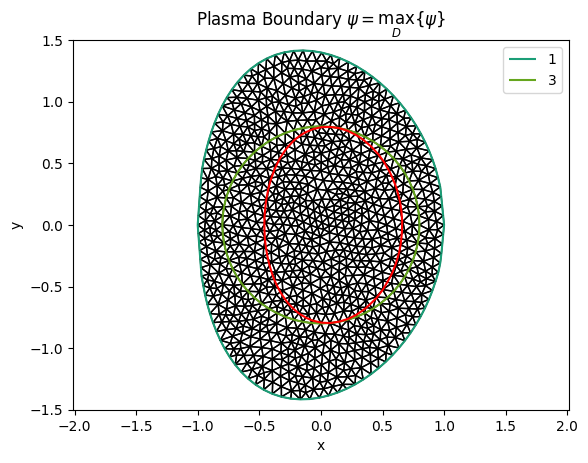

In [17]:
# Plot
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.contour(X, Y, PSI, levels=[psi0], colors='red')
plt.title(r"Plasma Boundary $\psi = \max_{D}\{\psi\}$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

### STEP 4: ACTUALLY UPDATE THE PLASMA BOUNDARY

Here I tought I can do this in two ways:
1. Introduce within the vacuum vessel region an indicator function which is 1 inside $\Omega_p$ and 0 outside, then I simply multiply $G(x,\psi)$ on the r.h.s by this indicator function. Update the indicatore function every iteration based on the computed value of $\psi_0$.
2. Make the contour an actual line in the .msh file and modify it at each iteration dividing the plasma vessel into two regions. To do so I would need to extract somehow the edges of the new plasma boundary and to impose such edges as a new boundary for the plasma region in the .msh file.

To start, the method 1 which is way simpler is employed.

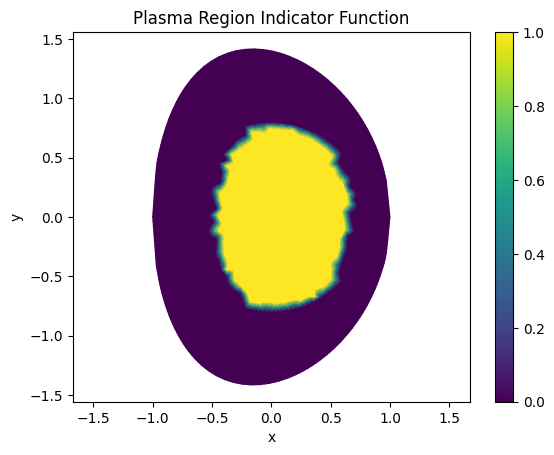

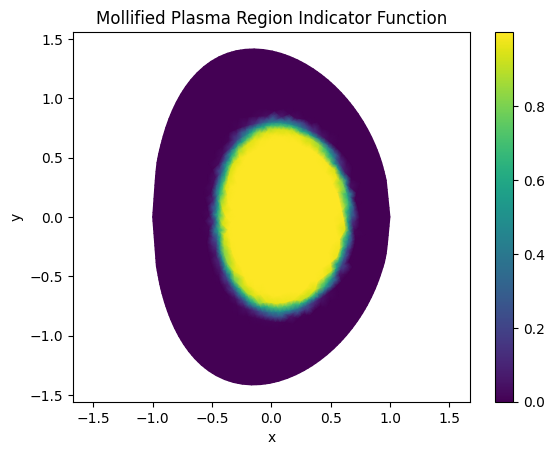

In [51]:
from firedrake.__future__ import interpolate # Firedrake mi ha detto di importare questo con un warning

# Indicator function for the plasma region

# Firedrake Function format:
#Plasma_Indicator = Function(V)
Plasma_Indicator = assemble(interpolate(conditional(psi > psi0_func, 1.0, 0.0), V))

# Mollified mask using the new interpolate behavior
epsilon = 0.05
mollified_mask = assemble(interpolate(0.5 + 0.5 * tanh((psi - psi0) / (epsilon * psi0)),V))

# Plot the mask
fig, ax = plt.subplots()
plt.colorbar(tripcolor(Plasma_Indicator, axes=ax))
plt.title("Plasma Region Indicator Function")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

# Plot the mollified mask
fig, ax = plt.subplots()
plt.colorbar(tripcolor(mollified_mask, axes=ax))
plt.title("Mollified Plasma Region Indicator Function")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

## STEP 5: try to perform one fixed point iteration

Within the Grad-Shafranov equation, the r.h.s. $G(x,\psi)$ is actually expressed as a function of $\psi$ rather then of $y$:

\begin{equation}
    - \Delta^* \psi = \begin{cases}
        &G(x,\psi) \quad  &\text{in}\  \Omega_p(\psi) \\
        &0  \quad &\text{in}\  \Omega_{vessel}/\Omega_p(\psi).
        \end{cases}
\end{equation}

It follows that the indicator function must be adapted to such r.h.s. which is function of $x$ and $\psi$.

In [ ]:
# Import Mesh:
n = 32
mesh = UnitSquareMesh(n, n)

# Define Function Space
V = FunctionSpace(mesh, 'P', 2)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

# Define G function:
def G(x,psi_old):
  return x**2 + 1

# Initialize the mask and the function:
psi = Function(V)
phi = TestFunction(V)
psi_mask = Function(V)
psi_old = Function(V)

psi_old.interpolate(Constant(0.0)) # Initial guess
psi_mask.interpolate(Constant(1.0)) # Initial plasma region

# Define boundary conditions:
bc = DirichletBC(V, 0.0, 'on_boundary')

# Define limiter points:
#limiter_points = [(0.8, 0.15), (0.2, 0.5), (0.8, 0.75)]
limiter_points = [(0.8,0.5)]

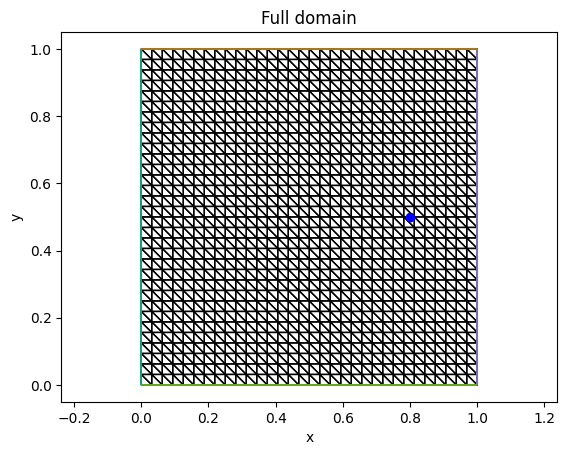

In [ ]:
# Plot the mesh:
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
plt.title(r"Full domain")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

In [ ]:
# Create a grid to plot contours lines:
xx = np.linspace(0, 1, n)
yy = np.linspace(0, 1, n)
X, Y = np.meshgrid(xx, yy)

In [ ]:
# Define variational formulation:
def GS_varf_Picard(G, phi, psi, psi_old, psi_mask):
    # Define the bilinear form:
    a  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx \
        - (psi_mask * G(x,psi_old) * phi) * dx

    # Define the r.h.s using Picard (fixed point) iteration:
    #L = psi_mask * G(x,psi_old) * phi * dx
    #L = G(x,psi_old) * phi * dx

    return a

# Update plasma boundary:
def find_plasma_boundary(psi, limiter_points):
    psi_vals = []
    for (x_pt, y_pt) in limiter_points:
        try:
            psi_vals.append(psi.at((x_pt, y_pt)))
            print(f"psi({x_pt}, {y_pt}) = {psi_vals[-1]}")
        except:
            raise ValueError(f"Point {(x_pt, y_pt)} outside domain!")

    return max(psi_vals)

psi(0.8, 0.5) = 0.07183057883226096
Magnetic surface at the limiter points: 0.07183057883226096


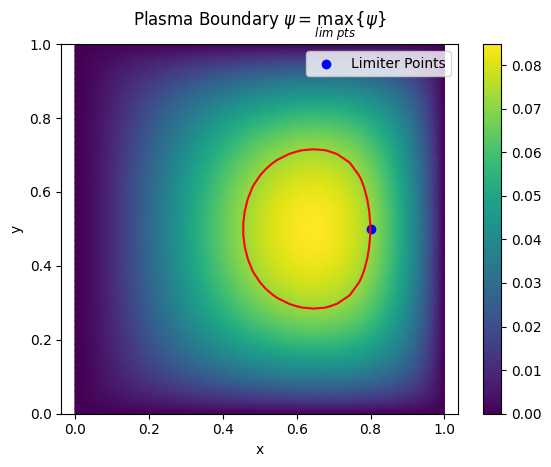

In [ ]:
# Define the variational problem:
a = GS_varf_Picard(G, phi, psi, psi_old, psi_mask)
solve(a == 0, psi, bcs=bc)

# Find the magnetic surface that updates the plasma boundary:
psi0 = find_plasma_boundary(psi, limiter_points)
print(f"Magnetic surface at the limiter points: {psi0}")

# Evaluate the function on the grid
PSI = np.zeros_like(X)
for i in range(n):
    for j in range(n):
        point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
        try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
        except:
            PSI[j, i] = np.nan         # Mark outside points as nan

# Plot the solution at this iteration:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(psi, axes=ax))
plt.contour(X, Y, PSI, levels=[psi0], colors='red')
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
plt.title(r"Plasma Boundary $\psi = \max_{lim\ pts}\{\psi\}$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

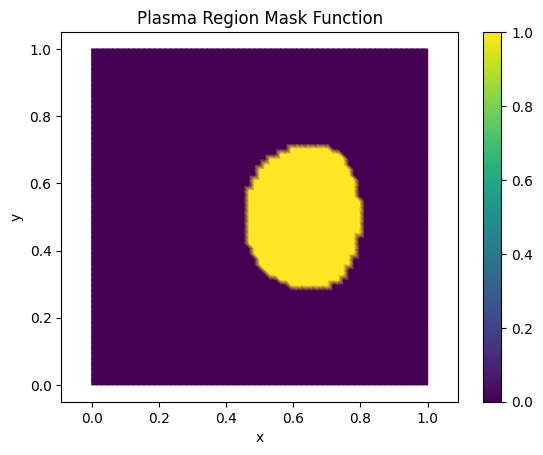

In [ ]:
# Update the mask:
psi_limiter = Function(V)
psi_limiter.interpolate(Constant(psi0))
psi_mask.interpolate(conditional(psi > psi_limiter, 1.0, 0.0))

# Plot the mask:
fig, ax = plt.subplots()
plt.colorbar(tripcolor(psi_mask, axes=ax))
plt.title("Plasma Region Mask Function")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

Perform another iteration with updated plasma boundary mask!

In [ ]:
def single_iteration_fixed_point(G, phi, psi, psi0, psi_old, limiter_points, n):
    
    psi_limiter = Function(V)
    psi_limiter.interpolate(Constant(psi0))
    psi_mask.interpolate(conditional(psi > psi_limiter, 1.0, 0.0))

    # Define the variational problem:
    a = GS_varf_Picard(G, phi, psi, psi_old, psi_mask)
    solve(a == 0, psi, bcs=bc)

    # Find the magnetic surface that updates the plasma boundary:
    psi0 = find_plasma_boundary(psi, limiter_points)
    print(f"Magnetic surface at the limiter points: {psi0}")

    # Evaluate the function on the grid to plot contours lines:
    PSI = np.zeros_like(X)
    for i in range(n):
        for j in range(n):
            point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
        try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
        except:
            PSI[j, i] = np.nan         # Mark outside points as nan

    # Plot the solution at this iteration:
    fig, ax = plt.subplots()
    fig.colorbar(tripcolor(psi, axes=ax))
    plt.contour(X, Y, PSI, levels=[psi0], colors='red')
    plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
    plt.title(r"Plasma Boundary $\psi = \max_{lim\ pts}\{\psi\}$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.axis('equal')
    plt.show()

    return psi, psi0, psi_mask

Another few of iterations to see if the plasma boundary eventually re-shapes:

In [ ]:
psi, psi0, psi_mask = single_iteration_fixed_point(G, phi, psi, psi0, psi_old, limiter_points, n)

psi(0.8, 0.5) = 0.01211207160157886
Magnetic surface at the limiter points: 0.01211207160157886


KeyboardInterrupt: 